# Feature Importance with SHAP values

In [121]:
# Imports
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import matplotlib.pyplot as plt
import shap

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Step 0 -- Data Exploration & Preprocessing (copy)

In [122]:
# Adult dataset
data_adult = fetch_openml("adult", version=2, as_frame=True)
X_adult = data_adult.data
y_adult = data_adult.target
feature_subset = ['age', 'education-num', 'race', 'sex', 'hours-per-week']
X_adult = X_adult[feature_subset]
categorical_cols = X_adult.select_dtypes(include="category").columns
encoder = OrdinalEncoder()
X_adult = X_adult.copy()
X_adult.loc[:, categorical_cols] = encoder.fit_transform(X_adult[categorical_cols])

# Student performance dataset
data_students = fetch_ucirepo(id=320) 
X_students = data_students.data.features 
Y_students = data_students.data.targets 
Y_students_G3 = Y_students['G3'] # only the last, final grade (single-target)
X_students = pd.get_dummies(X_students) # one-hot encode categorical features
selected_features = ['failures', 'absences', 'goout', 'studytime', 'age'] # for visualization purposes, use only a subset of features
X_students_sub = X_students[selected_features]

# Step 2 -- Feature Importance with SHAP values

SHAP (SHapley Additive exPlanations) is a unified framework for interpreting model predictions.  
It assigns each feature an importance value for a given prediction based on ideas from cooperative game theory.

Key Ideas:
- Each feature is viewed as a "player" in a game.
- The "payout" is the model's prediction.
- SHAP computes how much each feature contributes to the prediction, fairly, by averaging over all possible feature combinations.

Why SHAP?
- Works for both classification and regression.
- Offers **global** (feature-level) and **local** (instance-level) explanations.
- The TreeExplainer variant is efficient for tree-based models (like Random Forests).


## Step 2.1 -- SHAP Local Importance (Regression)

#### Student Performance

In [123]:
# train a linear regression model
X_train, X_test, y_train, y_test = train_test_split(X_students_sub, Y_students_G3, random_state=42)
lr = LinearRegression()
lr.fit(X_train, y_train)

# Baseline: Always predicts the average grade
dummy_reg = DummyRegressor(strategy="mean")
dummy_reg.fit(X_train, y_train)

# Evaluate
baseline_mse = mean_squared_error(y_test, dummy_reg.predict(X_test))
model_mse = mean_squared_error(y_test, lr.predict(X_test))

print(f"Baseline Mean-Squared-Error: {baseline_mse:.3f}")
print(f"Linear Regression Mean-Squared-Error: {model_mse:.3f}")

Baseline Mean-Squared-Error: 10.271
Linear Regression Mean-Squared-Error: 8.690


#### 🔍 Understanding SHAP for Linear Regression
We are using a simple linear regression model to predict the final student grade.
- Each feature contributes to the prediction through a weighted sum.
- The SHAP value for a feature is simply:
SHAP = coefficient × (feature value − mean feature value)
- The base value is the model’s intercept (i.e., prediction at average input).

We manually compute:
- The model's prediction using the intercept and weighted features.
- The SHAP explanation, which should match this exactly.

In [124]:
# obtain SHAP values
explainer = shap.Explainer(lr, X_train)
shap_values = explainer(X_test)

In [125]:
# pick a test sample whose prediction we'd like to explain
i = 5
x = X_test.iloc[i]

In [126]:
# SHAP values for the test sample we picked
shap_values[i]

.values =
array([ 0.33862376, -0.01192322,  0.16973329,  0.72594167,  0.00538644])

.base_values =
np.float64(11.992071945649798)

.data =
array([ 0,  6,  2,  3, 16])

In [127]:
# prediction for the test sample
pred = lr.predict(X_test.iloc[[i]])[0]
print(f"Linear regression prediction: {pred:.2f}")

# base_value + sum(SHAP values)
shap_sum = shap_values[i].base_values + shap_values[i].values.sum()
print(f"base_value + sum(SHAP values): {shap_sum:.2f}")

Linear regression prediction: 13.22
base_value + sum(SHAP values): 13.22


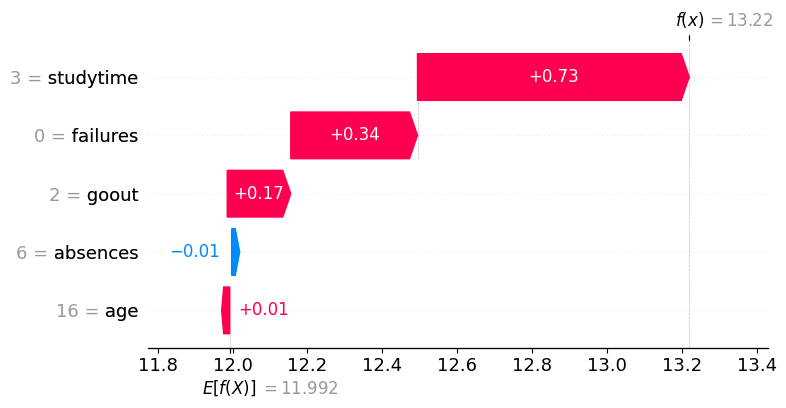

In [128]:
# visualize the sum of SHAP values as a waterfall plot
shap.plots.waterfall(shap_values[i])

<div style="border: 1px solid #ffcc00; background-color: #fff8e1; padding: 10px; border-radius: 5px; color: black;">
<b>❓ Question:</b> What does the SHAP waterfall plot tell us?
</div>

<details>
<summary>💬 Click to show explanation</summary>

<div style="border: 1px solid #007acc; background-color: #e6f2ff; padding: 10px; border-radius: 5px; color: black;">
<b>📈 Summary:</b>

- Model prediction: 13.22 (sum of student’s final grades)
- Model baseline (E[f(x)]): 11.99 (average prediction across all students)
- The model moved from 11.99 → 13.22 due to the individual feature values

<b>Key contributors:</b>
- ⬆️ <b>Studytime = 3</b> (i.e., high study time): pushed prediction up by +0.73
- ⬆️ <b>Failures = 0</b>: pushed prediction up by +0.34
- ⬆️ <b>Goout = 2</b>: moderate socializing also contributed positively (+0.17)
- ⬇️ <b>Absences = 6</b>: slightly lowered the prediction (–0.01)
- ➡️ <b>Age = 16</b>: had negligible effect

This student’s relatively strong study habits and clean record (no failures) helped the model predict a higher total grade. Still, the model underestimates the true outcome of 19.
</div>

</details>


<div style="border: 1px solid #ffcc00; background-color: #fff8e1; padding: 10px; border-radius: 5px; color: black;">
<b>🔍 Task:</b> Find a student the model predicts poorly and understand what went wrong.

</details>


In [129]:
# your code
...

# Tip: you could look at 
#   i = 0


#### Another way to visualize this: SHAP Force Plot

A **SHAP force plot** visually explains a single model prediction by showing how each feature pushes the prediction higher or lower relative to a baseline (the model’s expected value).

- **Red arrows** push the prediction **up** (positive SHAP values).
- **Blue arrows** push it **down** (negative SHAP values).
- The **baseline** is typically the average model output.
- The **final prediction** is the result of adding all SHAP values to the baseline.

This helps you see *why* the model made a specific decision.

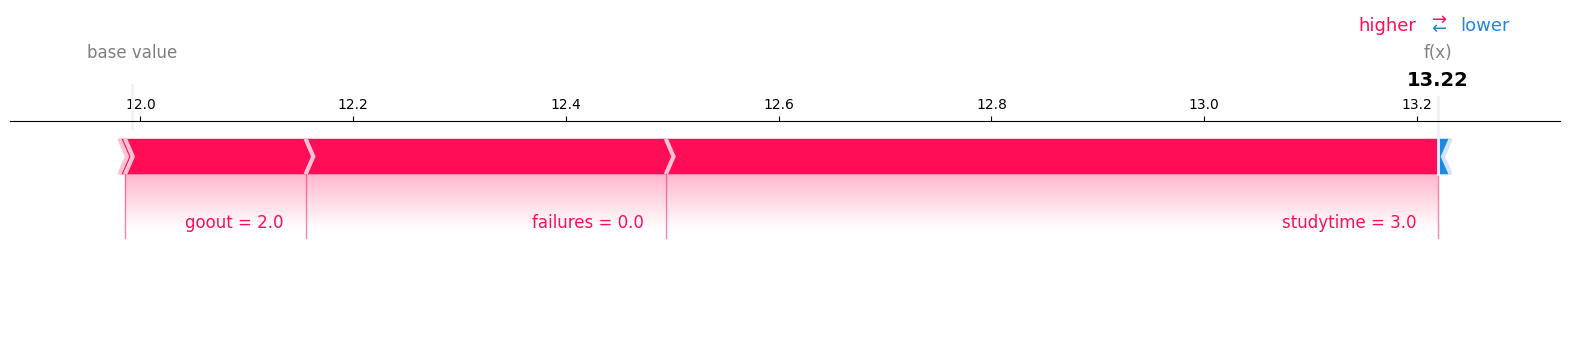

In [130]:
# Force plot version of local SHAP values
shap.plots.force(shap_values[5], matplotlib=True)

<div style="border: 1px solid #ffcc00; background-color: #fff8e1; padding: 10px; border-radius: 5px; color: black;">
<b>🔍 Task:</b> Compare force plots for different students.

</details>

In [131]:
# your code
...

## Step 2.2 -- Global Importance (Regression)

### 📊 SHAP Summary Plot (Bar Version)

This plot shows the **overall importance of each feature** in the model’s predictions.

- Each bar represents the **mean absolute SHAP value** of a feature across all samples.
- Taller bars mean the feature contributed more (on average) to predictions.
- This helps identify which features the model relies on most — regardless of direction.

Use this to **rank feature influence** in a global, model-wide sense.

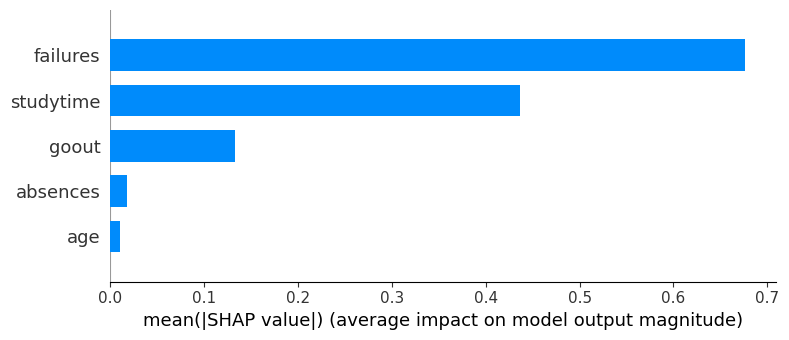

In [132]:
# create summary plot for overall feature importance
shap.summary_plot(shap_values, X_test, plot_type="bar")

### 🐝 SHAP Beehive Plot (Summary Plot)

The beehive-style summary plot visualizes both the **importance** and the **effect** of each feature across the dataset:

- Each point is a sample; color indicates the **feature value** (e.g., blue = low, red = high).
- X-position shows the **SHAP value** (positive = pushes prediction up; negative = pushes it down).
- Features are sorted by overall impact (mean |SHAP|).

This plot helps you understand:
- Which features matter most,
- Whether high or low values of a feature increase predictions,
- How consistently the model responds to changes in input values.

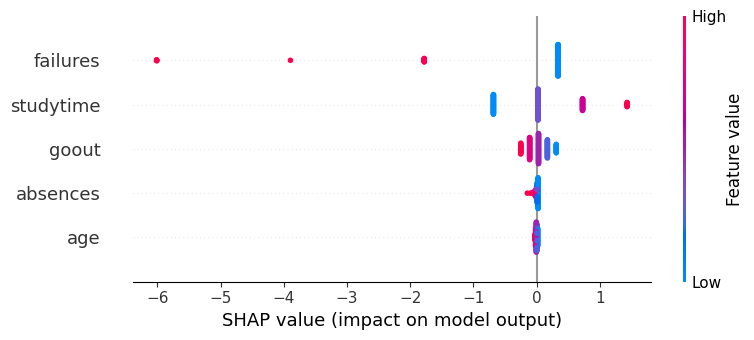

In [133]:
# Create SHAP summary plot (beehive version)
shap.summary_plot(shap_values, X_test)

<div style="border: 1px solid #ffcc00; background-color: #fff8e1; padding: 10px; border-radius: 5px; color: black;">
<b>❓ Question:</b> What insights can we draw from this SHAP beehive plot?
</div>

<details>
<summary>💬 Click to show explanation</summary>

<div style="border: 1px solid #007acc; background-color: #e6f2ff; padding: 10px; border-radius: 5px; color: black;">
<b>📊 Interpretation:</b>

- **failures** has the strongest (and most negative) effect on model predictions. Even a small number of failures can significantly lower the predicted grade sum.
- **studytime** tends to increase predictions: students who study more usually get better predicted outcomes.
- **goout** shows a negative relationship—high values (i.e., going out more) tend to lower predicted grades.
- **absences** and **age** have only minor effects in this model.

Note how color helps:
- **Red dots** (high feature values) and **blue dots** (low values) let us see *how* the feature influences the prediction—not just how much.

</div>
</details>


### 📈 SHAP Dependence Plots:

Dependence plots help us understand how the SHAP value (i.e., a feature's impact on a prediction) varies with the feature’s value.

Each point represents one student. The x-axis shows the value of the feature; the y-axis shows the feature’s SHAP value (its contribution to the prediction).  
Color indicates the value of another interacting feature that most strongly influences the SHAP value.

Use these plots to spot trends, thresholds, and interactions between features.


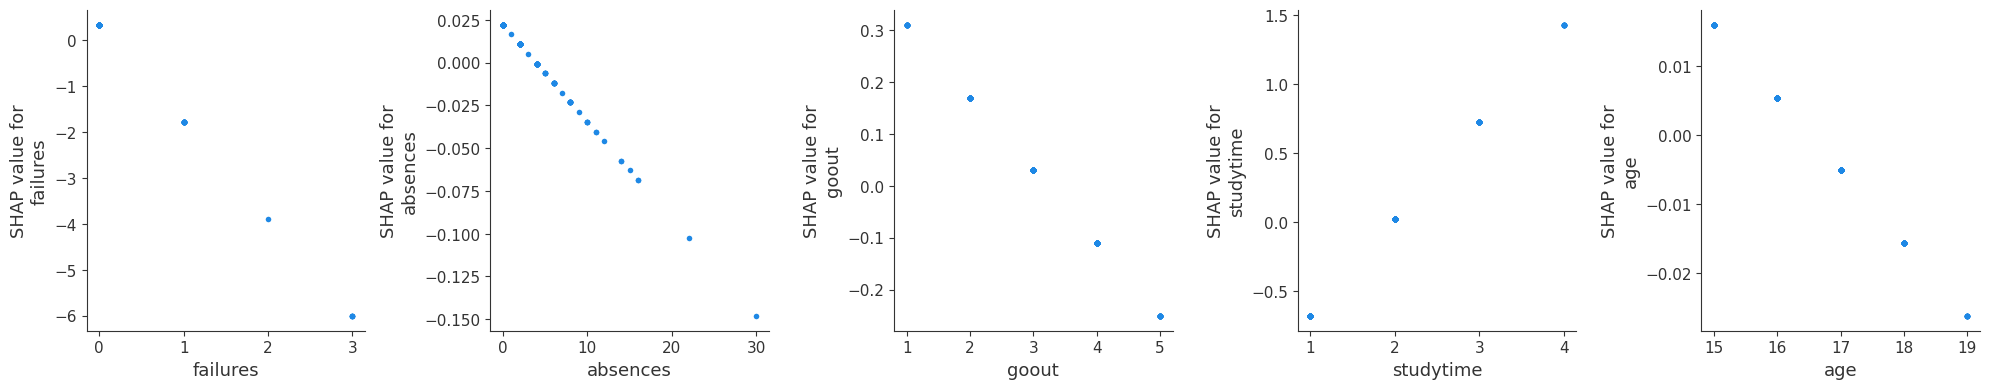

In [134]:
features = X_test.columns
fig, axes = plt.subplots(1, len(features), figsize=(4 * len(features), 4))

for ax, feat in zip(axes, features):
    shap.dependence_plot(
        ind=feat,
        shap_values=shap_values.values,
        features=shap_values.data,
        feature_names=X_test.columns,
        ax=ax,
        interaction_index=None,
        show=False
    )

plt.tight_layout()
plt.show()

<div style="border: 1px solid #ffcc00; background-color: #fff8e1; padding: 10px; border-radius: 5px; color: black;">
<b>❓ Question:</b> Why are all dots in the SHAP dependence plots aligned in a straight line?
</div>

<details>
<summary>💬 Click to show explanation</summary>

<div style="border: 1px solid #007acc; background-color: #e6f2ff; padding: 10px; border-radius: 5px; color: black;">
<b>📈 Explanation:</b>

This happens because we're using a <b>linear regression model</b>. 
</div>

</details>


## Step 2.3 -- SHAP works for any predictive model

However, the behavior of SHAP values depends on the model.
- For linear models, SHAP values reduce to the weighted contributions of individual features, resulting in purely additive, linear effects — as you've seen with perfectly aligned dots in dependence plots.
- For nonlinear models (e.g., trees, neural nets), SHAP captures complex interactions and conditional dependencies, often producing curved or scattered patterns in dependence plots.

In [135]:
# Train a new model
rf = RandomForestRegressor(random_state=42, n_estimators=500)
rf.fit(X_train, y_train)

# Compute SHAP values
explainer_rf = shap.Explainer(rf, X_train)
shap_values_rf = explainer_rf(X_test)

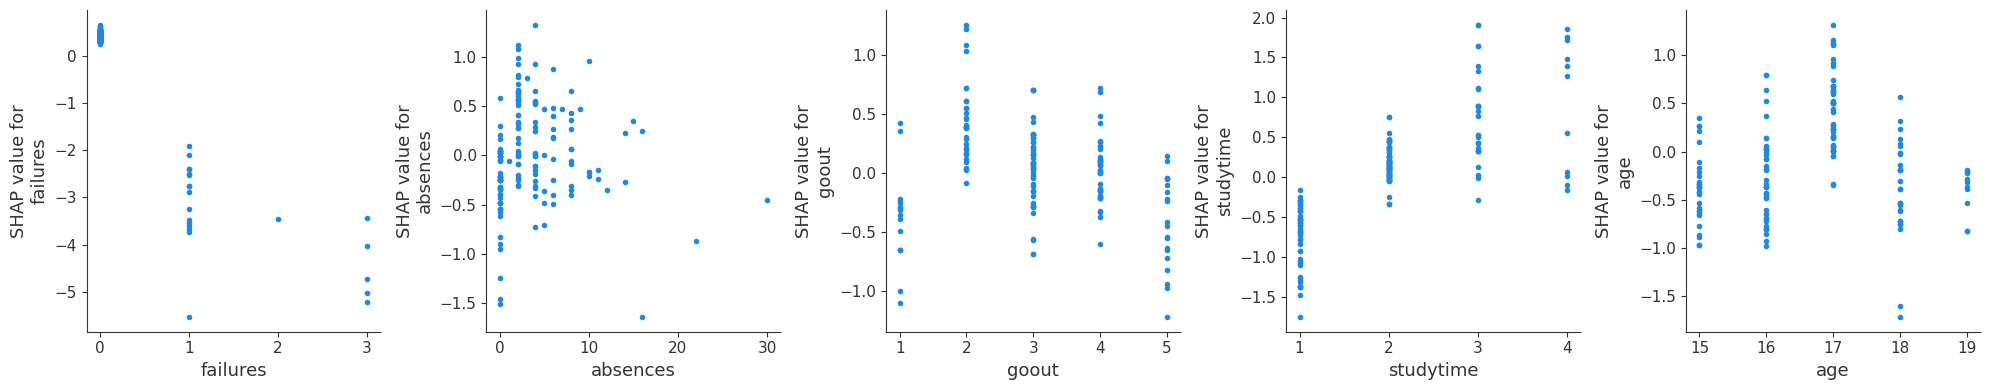

In [136]:
# Dependence plots
fig, axes = plt.subplots(1, len(features), figsize=(4 * len(features), 4))

for ax, feat in zip(axes, features):
    shap.dependence_plot(
        ind=feat,
        shap_values=shap_values_rf.values,
        features=X_test,
        feature_names=X_test.columns,
        ax=ax,
        show=False,
        interaction_index=None  # no hue
    )

plt.tight_layout()
plt.show()

<div style="border: 1px solid #ffcc00; background-color: #fff8e1; padding: 10px; border-radius: 5px; color: black;">
<b>❓ Question:</b> What patterns can we observe here that would not have been visible in the other types of plots?
</div>

<details>
<summary>💬 Click to show explanation</summary>

<div style="border: 1px solid #007acc; background-color: #e6f2ff; padding: 10px; border-radius: 5px; color: black;">
<b>📈 Summary:</b>

Unlike bar or beehive plots, SHAP dependence plots reveal how the *same feature value* can lead to different impacts depending on the context. This is only possible with non-linear models like Random Forests.

- For example, **failures = 1** results in SHAP values ranging from ~0 to -5, depending on other features—highlighting interaction effects.
- **studytime** also shows spread: the same number of hours studied can be helpful or not depending on the rest of the student’s profile.

This variation was *not visible* in the linear model’s plots, where all points lay on a line. The dependence plot is essential for uncovering such **context-dependent feature contributions**.

</div>
</details>


## Step 2.4 -- Your turn!

<div style="border: 1px solid #ffcc00; background-color: #fff8e1; padding: 10px; border-radius: 5px; color: black;">
<b>🧠 Task:</b> Use SHAP values to analyze model predictions on the <code>Adult</code> dataset. 
</br>


Try:
<ul>
  <li>Inspecting <b>global feature importances</b> using summary plots</li>
  <li>Creating <b>dependence plots</b> to visualize feature effects</li>
  <li>Generating <b>force plots</b> or <b>waterfall plots</b> to understand wrong predictions on individual samples</li>
</ul>

Do you think, the model is fair? Or can you detect biases?
</div>


In [137]:
# Split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X_adult, y_adult, random_state=42)

# Train a classifier -- how about Gradient Boosting this time??
clf = HistGradientBoostingClassifier(random_state=42)
clf.fit(X_train, y_train)

# Verify that the model works
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
baseline_acc = accuracy_score(y_test, dummy_clf.predict(X_test))
model_acc = accuracy_score(y_test, clf.predict(X_test))
print(f"Baseline accuracy: {baseline_acc:.3f}")
print(f"Gradient Boosting accuracy: {model_acc:.3f}")

Baseline accuracy: 0.766
Gradient Boosting accuracy: 0.814


In [138]:
# SHAP values
explainer = shap.Explainer(clf, X_train)
shap_values = explainer.shap_values(X_test)

 98%|===================| 11996/12211 [00:19<00:00]        

In [139]:
# your code
...

<div style="border: 1px solid #007acc; background-color: #e6f2ff; padding: 10px; border-radius: 5px; color: black;">
<b>ℹ️ Want to explore more?</b><br>
Check out <a href="https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/" target="_blank">this excellent non-technical guide</a> by Aidan Cooper.  
It walks through SHAP analysis in detail using a different dataset and provides great examples and intuition.

Also worth a look: The <a href="https://shap.readthedocs.io/en/stable/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html#" target="_blank">SHAP documentation</a> with lots of detailed explanations and interactive examples.
</div>